In [10]:
import json

import wandb

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12          # Base font size
plt.rcParams['axes.titlesize'] = 18     # Axes title
plt.rcParams['axes.labelsize'] = 12     # X and Y labels
plt.rcParams['xtick.labelsize'] = 13    # X tick labels
plt.rcParams['ytick.labelsize'] = 13    # Y tick labels
plt.rcParams['legend.fontsize'] = 16    # Legend
plt.rcParams['figure.titlesize'] = 22   # Figure title (suptitle)

In [11]:
wandb.login()
api = wandb.Api()

WANDB_PROJECT_ENTITY = "hms-hslu-aicomp-hs25"

# WANDB_PROJECT_NAME = "hms-aicomp-cnn-architectures"
WANDB_PROJECT_NAME = "hms-aicomp-multispec-cnn-architectures"

In [12]:
runs = api.runs(f"{WANDB_PROJECT_ENTITY}/{WANDB_PROJECT_NAME}")
print(f"Found {len(runs)} runs")

Found 50 runs


In [13]:
runs_data = []
for run in runs:
    run_config = json.loads(run.config)
    run_metrics = json.loads(run.summary_metrics)

    run_dict = {
        "id": run.id,
        "name": run.name,
        "fold": run_config["fold"]["value"],
        "architecture": run_config["architecture"]["value"],
        "val_kl_div": run_metrics["best_val_kl_div"],
        "runtime": run_metrics["_runtime"],
    }
    runs_data.append(run_dict)

runs_df = pd.DataFrame(runs_data)
runs_df

,id,name,fold,architecture,val_kl_div,runtime
0,syebktef,tf_efficientnet_b0_ns-multispec-fold0,0,tf_efficientnet_b0_ns,0.734498,1827
1,0obvypr5,tf_efficientnet_b0_ns-multispec-fold1,1,tf_efficientnet_b0_ns,0.666102,1908
2,fw9a0a96,tf_efficientnet_b0_ns-multispec-fold2,2,tf_efficientnet_b0_ns,0.592826,1906
3,k2j0if6k,tf_efficientnet_b0_ns-multispec-fold3,3,tf_efficientnet_b0_ns,0.716500,1903
4,h4y596ug,tf_efficientnet_b0_ns-multispec-fold4,4,tf_efficientnet_b0_ns,0.706746,1927
5,ovyen512,tf_efficientnet_b1_ns-multispec-fold0,0,tf_efficientnet_b1_ns,0.780081,2379
6,ta3ii4e4,tf_efficientnet_b1_ns-multispec-fold1,1,tf_efficientnet_b1_ns,0.668937,2382
7,wb9wp5n1,tf_efficientnet_b1_ns-multispec-fold2,2,tf_efficientnet_b1_ns,0.591918,2382
8,l67sgg9w,tf_efficientnet_b1_ns-multispec-fold3,3,tf_efficientnet_b1_ns,0.704456,2413
9,svjiudoh,tf_efficientnet_b1_ns-multispec-fold4,4,tf_efficientnet_b1_ns,0.670762,2383


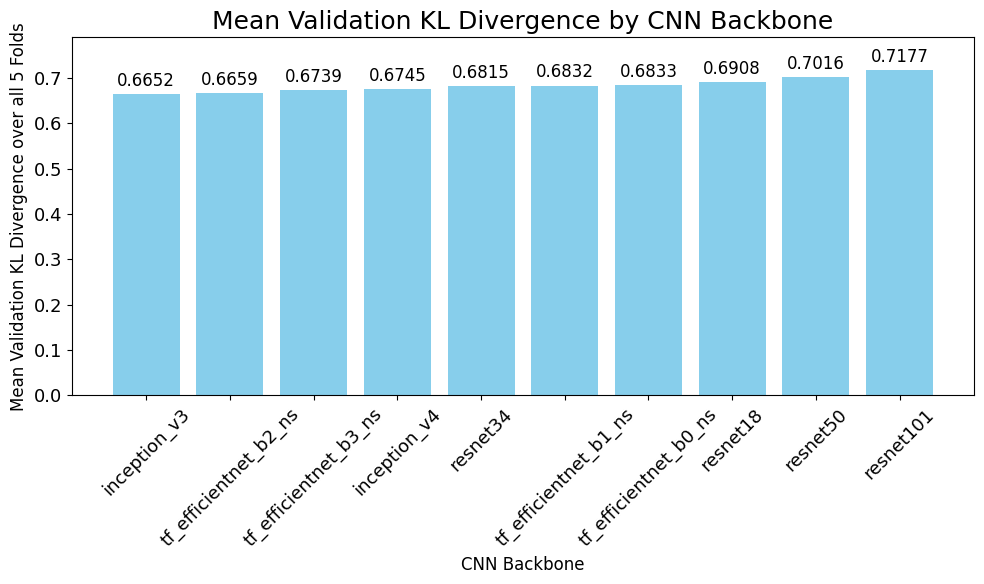

In [14]:
performance_df = runs_df.groupby("architecture")["val_kl_div"].mean().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(performance_df.index, performance_df.values, color='skyblue')
ax.set_xlabel("CNN Backbone")
ax.set_ylabel("Mean Validation KL Divergence over all 5 Folds")
ax.set_title("Mean Validation KL Divergence by CNN Backbone")
ax.set_ylim(0, performance_df.values.max() * 1.1)
ax.bar_label(bars, fmt='%.4f', padding=3)
plt.xticks(rotation=45)
fig.tight_layout()

fig.savefig("cnn_backbone_performance.svg")

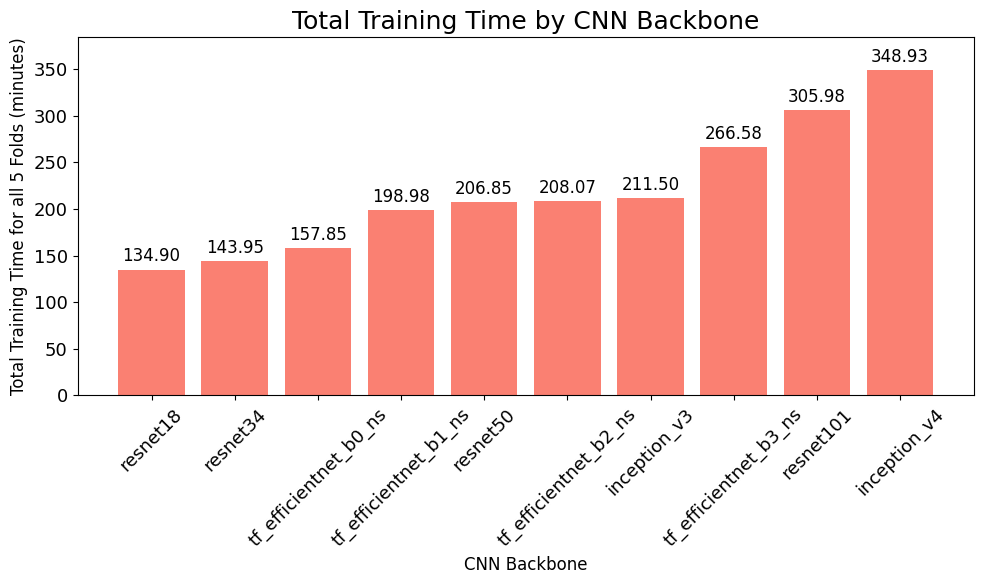

In [16]:
runtime_df = runs_df.groupby("architecture")["runtime"].sum().sort_values()
runtime_df = runtime_df / 60

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(runtime_df.index, runtime_df.values, color='salmon')
ax.set_xlabel("CNN Backbone")
ax.set_ylabel("Total Training Time for all 5 Folds (minutes)")
ax.set_title("Total Training Time by CNN Backbone")
ax.set_ylim(0, runtime_df.values.max() * 1.1)
ax.bar_label(bars, fmt='%.2f', padding=3)
plt.xticks(rotation=45)
fig.tight_layout()

fig.savefig("cnn_backbone_runtime.svg")